# Import Statements

In [ ]:
!pip install wrds --quiet
!pip install yfinance --quiet
!pip install datasets --quiet

import yfinance as yf
import wrds

import os

import numpy as np
import pandas as pd

from tqdm import tqdm

import json

import datetime

import matplotlib.pyplot as plt

import torch
from transformers import AutoTokenizer

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Global variables

In [ ]:
DATA_DIR = "/content/drive/My Drive/DL Proj/data/"

# Connect to WRDS

In [ ]:
# connect to wrds
conn = wrds.Connection(wrds_username='quantcrew')

Enter your WRDS username [quantcrew]:quantcrew
Enter your password:··········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [ ]:
# all the data I can access

libraries = conn.list_libraries()
print("Available libraries:", libraries)

tables = conn.list_tables('comp')
print("Tables in 'comp' library:", tables)

Available libraries: ['aha_sample', 'ahasamp', 'auditsmp', 'auditsmp_all', 'bank', 'bank_all', 'bank_premium_samp', 'banksamp', 'block', 'block_all', 'boardex_trial', 'boardsmp', 'bvd_amadeus_trial', 'bvd_bvdbankf_trial', 'bvd_orbis_trial', 'bvdsamp', 'calcbench_trial', 'calcbnch', 'cboe', 'cboe_all', 'cboe_sample', 'cboesamp', 'ciq', 'ciq_common', 'ciq_transcripts', 'ciqsamp', 'ciqsamp_capstrct', 'ciqsamp_common', 'ciqsamp_keydev', 'ciqsamp_pplintel', 'ciqsamp_ratings', 'ciqsamp_transactions', 'ciqsamp_transcripts', 'cisdmsmp', 'columnar', 'comp', 'comp_bank', 'comp_bank_daily', 'comp_execucomp', 'comp_global', 'comp_global_daily', 'comp_na_annual_all', 'comp_na_daily_all', 'comp_na_monthly_all', 'comp_segments_hist', 'comp_segments_hist_daily', 'compa', 'compb', 'compg', 'compm', 'compsamp', 'compsamp_all', 'compsamp_snapshot', 'compseg', 'comscore', 'comscore_2020', 'comscore_common', 'contrib', 'contrib_as_filed_financials', 'contrib_ceo_turnover', 'contrib_char_returns', 'contrib_

In [ ]:
list_all_table_comp_na_daily = conn.list_tables('comp_na_daily_all')
[x for x in list_all_table_comp_na_daily if "wrds" in x]

['wrds_idx_cst_current',
 'wrds_ratios',
 'wrds_seg_customer',
 'wrds_seg_geo',
 'wrds_seg_product',
 'wrds_segmerged']

In [ ]:
list_all_table_comp_na_daily = conn.list_tables('comp')
[x for x in list_all_table_comp_na_daily if "wrds" in x]

['wrds_g_exrate',
 'wrds_idx_cst_current',
 'wrds_ratios',
 'wrds_seg_customer',
 'wrds_seg_geo',
 'wrds_seg_product',
 'wrds_segmerged']

# Utility functions

In [ ]:
def load_securities_info(conn):
    query = """
            SELECT *
            FROM comp_na_daily_all.security
            """
    df = conn.raw_sql(query)
    return df


In [ ]:
def link_companyid_to_gvkey(conn):
    # WRDS_CIQSYMBOL
    # (https://wrds-www.wharton.upenn.edu/pages/wrds-research/database-linking-matrix/linking-capital-iq-with-compustat/)

    #



    return None

In [ ]:
def get_adjusted_prices(conn, gvkey_company):


    # Convert single string gvkey to list for uniform processing
    if isinstance(gvkey_company, str):
        gvkey_list = [gvkey_company]
    else:
        gvkey_list = gvkey_company  # Already a list

    # Format gvkey list for SQL query
    gvkey_str = "', '".join(gvkey_list)

    # SQL query to fetch daily stock price data
    sql_query = f"""
    SELECT *
    FROM comp_na_daily_all.sec_dprc
    WHERE gvkey IN ('{gvkey_str}')
    ORDER BY datadate ASC;
    """

    df_daily_price = conn.raw_sql(sql_query)
    df_daily_price['datadate'] = pd.to_datetime(df_daily_price['datadate'])  # Convert to datetime
    df_daily_price['price_adj'] = df_daily_price['prccd'] / df_daily_price['ajexdi']  # Compute adjusted price

    return df_daily_price[['datadate', 'gvkey', 'ajexdi', 'prccd', 'prcstd', 'price_adj']]

# Example usage:
df_single = get_adjusted_prices(conn, "004503")  # For single gvkey
df_multiple = get_adjusted_prices(conn, ["004503", "023546", "008606"])  # For multiple gvkeys

In [ ]:
df_info = load_securities_info(conn)

# Stock pool: S&P 500

In [ ]:
# libraries = db.list_libraries()
# print("Available libraries:", libraries)


sp500 = conn.raw_sql("""
                        select a.*, b.date, b.ret
                        from crsp.msp500list as a,
                        crsp.msf as b
                        where a.permno=b.permno
                        and b.date >= a.start and b.date<= a.ending
                        and b.date>='01/01/2000'
                        order by date;
                        """, date_cols=['start', 'ending', 'date'])
sp500

,permno,start,ending,date,ret
0,10107,1994-06-07,2024-12-31,2000-01-31,-0.16167
1,75186,1997-06-02,2024-12-31,2000-01-31,-0.062092
2,20482,1957-03-01,2024-12-31,2000-01-31,-0.098589
3,24010,1957-03-01,2024-12-31,2000-01-31,-0.031553
4,41080,1965-01-07,2024-12-31,2000-01-31,-0.208279
...,...,...,...,...,...
150519,80681,2014-04-02,2024-12-31,2024-12-31,-0.08059
150520,24985,1991-09-20,2024-12-31,2024-12-31,-0.048522
150521,77274,2004-07-01,2024-12-31,2024-12-31,0.006049
150522,14889,2016-02-01,2024-12-31,2024-12-31,-0.090985


In [ ]:
mse = conn.raw_sql("""
                        select comnam, ncusip, namedt, nameendt,
                        permno, shrcd, exchcd, hsiccd, ticker
                        from crsp.msenames
                        """, date_cols=['namedt', 'nameendt'])

# if nameendt is missing then set to today date
mse['nameendt']=mse['nameendt'].fillna(pd.to_datetime('today'))

In [ ]:
# Merge with SP500 data
sp500_full = pd.merge(sp500, mse, how = 'left', on = 'permno')

# Impose the date range restrictions
sp500_full = sp500_full.loc[(sp500_full.date>=sp500_full.namedt) \
                            & (sp500_full.date<=sp500_full.nameendt)]
sp500_full.sample(5)

,permno,start,ending,date,ret,comnam,ncusip,namedt,nameendt,shrcd,exchcd,hsiccd,ticker
1058496,40125,2017-04-04,2023-10-02,2023-01-31,0.084151,D X C TECHNOLOGY CO,23355L10,2021-03-17,2024-06-30,11,1,7376,DXC
800544,87447,2002-07-22,2024-12-31,2017-04-28,0.001491,UNITED PARCEL SERVICE INC,91131210,2014-01-08,2019-09-11,11,1,4215,UPS
652239,12872,2011-07-01,2024-12-31,2014-01-31,-0.051019,MARATHON PETROLEUM CORP,56585A10,2011-07-01,2024-12-31,11,1,2911,MPC
815949,13856,1957-03-01,2024-12-31,2017-08-31,-0.000643,PEPSICO INC,71344810,2004-06-10,2017-12-19,11,1,2086,PEP
1137732,45751,1987-08-06,2024-12-31,2024-11-29,0.068686,MARSH & MCLENNAN COS INC,57174810,2019-09-12,2024-12-31,11,1,6411,MMC


In [ ]:
# Linking with Compustat through CCM

ccm=conn.raw_sql("""
                  select gvkey, liid as iid, lpermno as permno, linktype, linkprim,
                  linkdt, linkenddt
                  from crsp.ccmxpf_linktable
                  where substr(linktype,1,1)='L'
                  and (linkprim ='C' or linkprim='P')
                  """, date_cols=['linkdt', 'linkenddt'])

# if linkenddt is missing then set to today date
ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))

In [ ]:
# Merge the CCM data with S&P500 data
# First just link by matching PERMNO
sp500ccm = pd.merge(sp500_full, ccm, how='left', on=['permno'])

# Then set link date bounds
sp500ccm = sp500ccm.loc[(sp500ccm['date']>=sp500ccm['linkdt'])\
                        &(sp500ccm['date']<=sp500ccm['linkenddt'])]
sp500ccm.sample(5)

,permno,start,ending,date,ret,comnam,ncusip,namedt,nameendt,shrcd,exchcd,hsiccd,ticker,gvkey,iid,linktype,linkprim,linkdt,linkenddt
90517,85913,1998-05-21,2024-12-31,2011-07-29,-0.084249,MARRIOTT INTERNATIONAL INC NEW,57190320,2004-06-10,2013-10-20,11,1,7011,MAR,028930,02,LC,P,1998-05-01,2025-03-05 15:32:04.725556
185106,76226,1994-09-30,2024-12-31,2024-04-30,-0.032286,PARAMOUNT GLOBAL,92556H20,2024-03-12,2024-12-31,11,3,4833,PARA,013714,03,LC,P,1994-10-01,2025-03-05 15:32:04.725556
113505,24942,1957-03-01,2020-04-03,2014-08-29,0.061364,RAYTHEON CO,75511150,2004-06-10,2020-04-02,11,1,3812,RTN,008972,01,LU,P,1962-02-28,2020-04-30 00:00:00.000000
118770,10516,1981-07-30,2024-12-31,2015-05-29,0.086948,ARCHER DANIELS MIDLAND CO,03948310,2012-10-31,2019-09-11,11,1,2046,ADM,001722,01,LC,P,1962-01-31,2025-03-05 15:32:04.725556
173641,85631,1989-12-21,2024-12-31,2022-10-31,0.147216,AUTODESK INC,05276910,2004-06-10,2024-03-11,11,3,7370,ADSK,001878,01,LU,P,1985-07-31,2025-03-05 15:32:04.725556


In [ ]:
# Rearrange columns for final output

sp500ccm = sp500ccm.drop(columns=['namedt', 'nameendt', \
                                  'linktype', 'linkprim', 'linkdt', 'linkenddt'])
sp500ccm = sp500ccm[['date', 'permno', 'comnam', 'ncusip', 'shrcd', 'exchcd', 'hsiccd', 'ticker', \
                     'gvkey', 'iid', 'start', 'ending', 'ret']]
sp500ccm.sample(5)

,date,permno,comnam,ncusip,shrcd,exchcd,hsiccd,ticker,gvkey,iid,start,ending,ret
148000,2019-04-30,13586,PENTAIR PLC,G7S00T10,12,1,3491,PNR,008463,01,2012-10-01,2024-12-31,-0.119973
68326,2008-08-29,89179,WELLPOINT INC,94973V10,11,1,6321,WLP,145046,01,2002-07-25,2024-12-31,0.006482
174106,2022-10-31,13407,META PLATFORMS INC,30303M10,11,3,7375,META,170617,01,2013-12-23,2024-12-31,-0.313384
41169,2005-02-28,77702,STARBUCKS CORP,85524410,11,3,5810,SBUX,025434,01,2000-06-08,2024-12-31,-0.040556
19524,2002-05-31,64311,NORFOLK SOUTHERN CORP,65584410,11,1,4731,NSC,007923,01,1982-06-03,2024-12-31,-0.009333


In [ ]:
cnt = sp500ccm.groupby(['date'])['permno'].count().reset_index().rename(columns={'permno':'npermno'})
cnt.sample(4)

,date,npermno
245,2020-06-30,501
22,2001-11-30,500
272,2022-09-30,499
111,2009-04-30,501


In [ ]:
sp500ccm[["ticker", "comnam", "gvkey"]].drop_duplicates()

,ticker,comnam,gvkey
0,MSFT,MICROSOFT CORP,012141
1,SCH,SCHWAB CHARLES CORP NEW,013988
3,ABT,ABBOTT LABORATORIES,001078
5,ETR,ENTERGY CORP NEW,007366
6,CUM,CUMMINS ENGINE INC,003650
...,...,...,...
189188,TPL,TEXAS PACIFIC LAND CORP,010504
189440,LII,LENNOX INTERNATIONAL INC,122380
189465,WDAY,WORKDAY INC,015044
189606,APO,APOLLO GLOBAL MANAGEMENT INC NEW,184254


In [ ]:
list_gvkey_sp500 = list(sp500ccm["gvkey"].drop_duplicates())
len(list_gvkey_sp500)

1037

# Load an arbitrary earnings call

In [ ]:
# load json file
with open(DATA_DIR + "batch_transcriptid_dict.json", "r") as f:
    batch_transcriptid_dict = json.load(f)

In [ ]:
# S&P 500 companyid
query = """
SELECT *
FROM comp.wrds_idx_cst_current
"""
df_index = conn.raw_sql(query)
# dict_id = dict(zip(df_index['companyname'], df_index['companyid']))
# company_ids = ", ".join(map(str, dict_id.values()))
print(df_index.columns)

df_mapping = df_index[["tic", "companyname", "companyid", "gvkey"]]
df_mapping.columns = ["ticker", "companyname", "companyid", "gvkey"]

df_mapping_filter_500 = df_mapping[df_mapping['gvkey'].isin(list_gvkey_sp500)].drop_duplicates().reset_index(drop=True)
list_companyid_sp500 = list(df_mapping_filter_500['companyid'])
len(list_companyid_sp500)

Index(['indexid', 'indexname', 'gvkey', 'iid', 'tic', 'companyname',
       'companyid', 'securityid', 'primaryflag', 'fromdate', 'constituentid',
       'tradingitemid'],
      dtype='object')


631

In [ ]:
# load earnings call details
df_earnings = pd.read_parquet(DATA_DIR + "df_earnings.parquet")
df_earnings_500 = df_earnings[df_earnings['companyid'].isin(list_companyid_sp500)]
len(df_earnings_500)

128743

In [ ]:
lsit_transcript_id_all = batch_transcriptid_dict.values()
list_transcript_id_all = [item for sublist in lsit_transcript_id_all for item in sublist]
len(list_transcript_id_all)

122959

In [ ]:
# build a function to find an arbitrady earnings call
array_ids = np.array(list_transcript_id_all)
id_random = np.random.choice(array_ids)
df_earnings_500[df_earnings_500['transcriptid'] == id_random].T

,364687
companyid,270747.0
keydevid,528606362.0
transcriptid,1242875.0
headline,"Fastenal Company, Q2 2017 Earnings Call, Jul 1..."
mostimportantdateutc,2017-07-12
mostimportanttimeutc,14:00:00
keydeveventtypeid,48.0
keydeveventtypename,Earnings Calls
companyname,Fastenal Company
transcriptcollectiontypeid,7


In [ ]:
all_id_company = df_earnings_500["companyid"].unique().astype(int).tolist()

In [ ]:
def fetch_transcript_detail(transcriptid):

    # find the batch index from batch_transcriptid_dict
    for key, value in batch_transcriptid_dict.items():
        if transcriptid in value:
            batch_index = key
            break

    # read batch transcrip text and person
    df_batch_text = pd.read_parquet(DATA_DIR + f"batch_{batch_index}_transcriptcomponent.parquet")
    df_batch_person = pd.read_parquet(DATA_DIR + f"batch_{batch_index}_transcript_person.parquet")

    # find the transcript detail
    df_transcript_detail = df_batch_text[df_batch_text['transcriptid'] == transcriptid].sort_values("componentorder")
    df_transcript_person = df_batch_person[df_batch_person['transcriptid'] == transcriptid]

    return df_transcript_detail, df_transcript_person

# call the function
df_transcript_detail, df_transcript_person = fetch_transcript_detail(id_random)

# Price data

In [ ]:
id_company = 406338

# given company id, need to find gvkey
gvkey_company = df_mapping_filter_500[df_mapping_filter_500['companyid'] == id_company]['gvkey'].iloc[0]
gvkey_company = str(gvkey_company)
gvkey_company

'004503'

In [ ]:
df_mapping_filter_500[df_mapping_filter_500['companyid'] == id_company]

,ticker,companyname,companyid,gvkey
39,XOM,Exxon Mobil Corporation,406338.0,004503


In [ ]:
sql_query = f"""
SELECT *
FROM comp_na_daily_all.sec_dprc
WHERE gvkey = '{gvkey_company}'
"""

df_daily_price = conn.raw_sql(sql_query)
print(df_daily_price.columns)
df_daily_price_filter = df_daily_price[['datadate', 'ajexdi', 'prccd', 'prcstd']]
df_daily_price_filter['price_adj'] = df_daily_price_filter['prccd'] / df_daily_price_filter['ajexdi']
df_daily_price_filter['datadate'] = pd.to_datetime(df_daily_price_filter['datadate'])

Index(['gvkey', 'iid', 'curcdd', 'adrrc', 'ajexdi', 'cshoc', 'cshtrd', 'dvi',
       'eps', 'epsmo', 'prccd', 'prchd', 'prcld', 'prcod', 'prcstd', 'qunit',
       'datadate'],
      dtype='object')


In [ ]:
df_daily_price_filter

,datadate,ajexdi,prccd,prcstd,price_adj
0,1990-08-01,4.0,52.125,3,13.03125
1,1990-08-02,4.0,53.25,3,13.3125
2,1990-08-03,4.0,53.125,3,13.28125
3,1990-08-06,4.0,54.25,3,13.5625
4,1990-08-07,4.0,53.375,3,13.34375
...,...,...,...,...,...
10371,2025-02-26,1.0,109.46,3,109.46
10372,2025-02-27,1.0,110.15,3,110.15
10373,2025-02-28,1.0,111.33,3,111.33
10374,2025-03-03,1.0,107.76,3,107.76


In [ ]:
df_mapping_filter_500

,ticker,companyname,companyid,gvkey
0,MMM,3M Company,289194.0,007435
1,T,AT&T Inc.,100231.0,009899
2,ABBV,AbbVie Inc.,141885706.0,016101
3,ABT,Abbott Laboratories,247483.0,001078
4,ACN,Accenture plc,972190.0,143357
...,...,...,...,...
626,FTI,TechnipFMC plc,1342651.0,030923
627,RIG,Transocean Ltd.,407172.0,028338
628,DDS,"Dillard's, Inc.",266847.0,003964
629,UIS,Unisys Corporation,310310.0,002504


In [ ]:
# compare it with Yahoo finance data
df_price_yahoo = yf.download('XOM', start='2000-01-01', auto_adjust=True).reset_index()
df_price_yahoo = df_price_yahoo[['Date', 'Close']]
df_price_yahoo.columns = ['datadate', 'price_adj']
df_price_yahoo['datadate'] = pd.to_datetime(df_price_yahoo['datadate'])

[*********************100%***********************]  1 of 1 completed


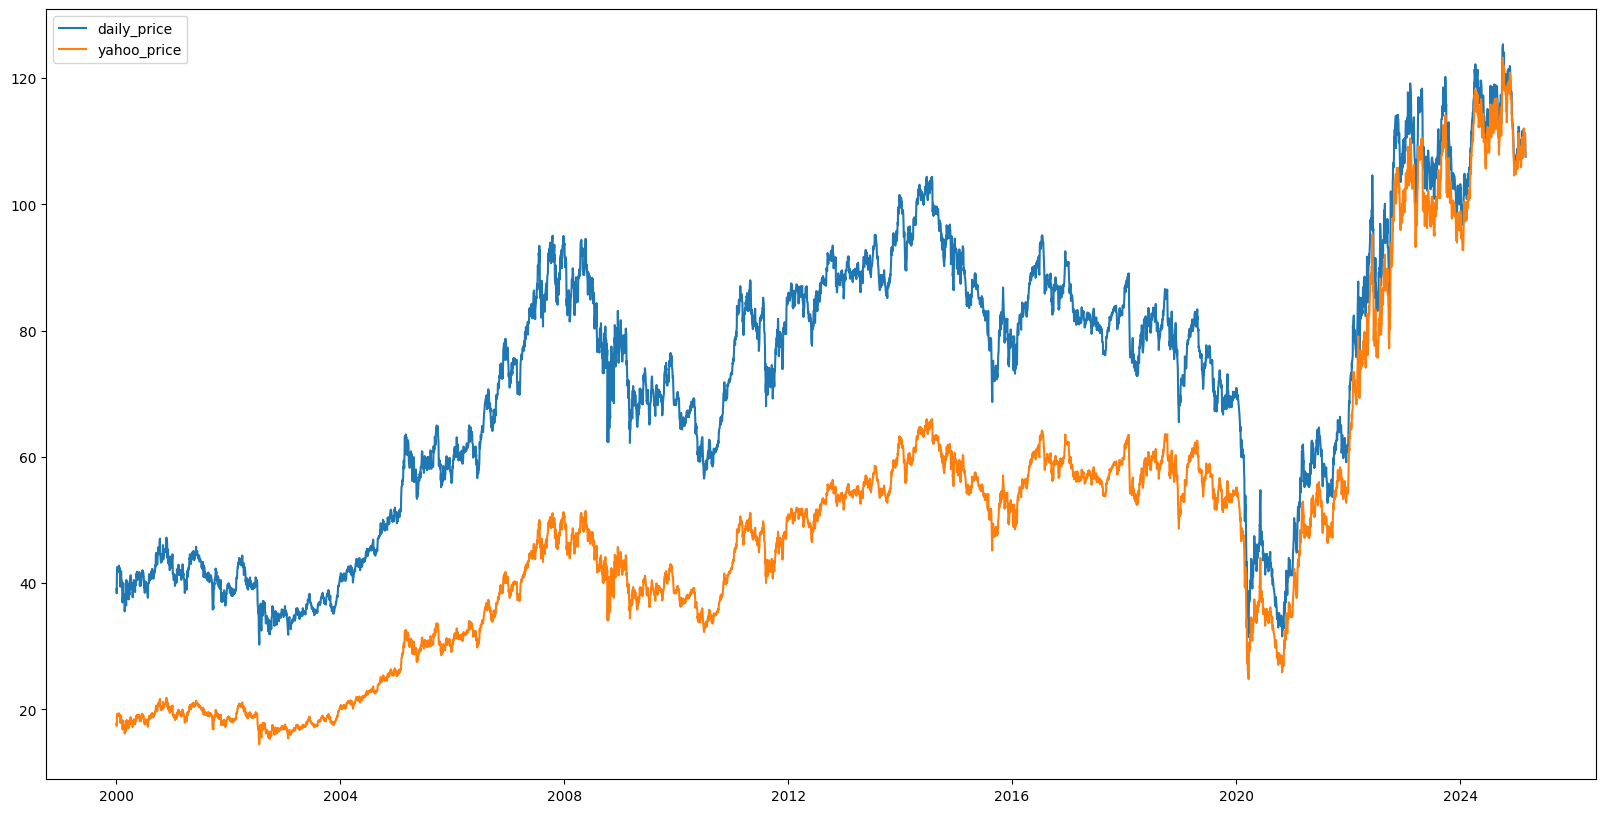

In [ ]:
df_compare = pd.merge(df_daily_price_filter[['datadate', 'price_adj']], df_price_yahoo, how='outer', on='datadate').dropna()

# plot the prices to see the difference
plt.figure(figsize=(20, 10))
plt.plot(df_compare['datadate'], df_compare['price_adj_x'], label='daily_price')
plt.plot(df_compare['datadate'], df_compare['price_adj_y'], label='yahoo_price')
plt.legend()
plt.show()

In [ ]:
# compare cum return
df_compare['return_x'] = df_compare['price_adj_x'].pct_change()
df_compare['cum_return_x'] = (1 + df_compare['return_x']).cumprod() - 1
df_compare['cum_return_x'].iloc[0] = 0

df_compare['return_y'] = df_compare['price_adj_y'].pct_change()
df_compare['cum_return_y'] = (1 + df_compare['return_y']).cumprod() - 1
df_compare['cum_return_y'].iloc[0] = 0

plt.figure(figsize=(20, 10))
plt.plot(df_compare['datadate'], df_compare['cum_return_x'], label='daily_price')
plt.plot(df_compare['datadate'], df_compare['cum_return_y'], label='yahoo_price')
plt.legend()
plt.show()

In [ ]:
from tqdm import tqdm
id_company_mapping_pvdata = {}
sp500 = yf.download("^GSPC", start="2000-01-01", end="2025-03-04", interval="1d").reset_index()
sp500.columns =  ['Date', 'Index', "High", "Low", "Open", "Volume"]
sp500["index_ret"] = np.log(sp500["Index"]) - np.log(sp500["Open"])
sp500["Date"] = pd.to_datetime(sp500["Date"])
def get_all_company_price_data(start, end):
  for id_company in tqdm(all_id_company):
    try:
      company_name = df_mapping_filter_500.loc[df_mapping_filter_500["companyid"] == id_company, "ticker"].values[0]
      df_price_yahoo = yf.download(company_name, start='2000-01-01', auto_adjust=True).reset_index()

      df_price_yahoo = df_price_yahoo[['Date', 'Close', "High", "Low", "Open", "Volume"]]
      df_price_yahoo.columns = ['Date', 'Close', "High", "Low", "Open", "Volume"]
      df_price_yahoo['Date'] = pd.to_datetime(df_price_yahoo['Date'])

      df_price_yahoo = pd.merge(df_price_yahoo, sp500[["Date", "Index", "index_ret"]], on = "Date", how = "left")
      df_price_yahoo["stock_ret"] = np.log(df_price_yahoo["Close"]) - np.log(df_price_yahoo["Open"])
      df_price_yahoo = df_price_yahoo.set_index("Date")
      id_company_mapping_pvdata[id_company] = df_price_yahoo
    except Exception as e:
      print(id_company,e)

get_all_company_price_data("2005-01-01","2024-12-31")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import numpy as np
def calculate_car(df, issue_date, risk_free_rate = 0, pre_event_window=60, event_window=20):
    idx = df.index.searchsorted(pd.Timestamp(issue_date))
    capm_data = df.iloc[idx - pre_event_window: idx]
    window_data = df.iloc[idx + 1 : idx + 1 + event_window]
    estimation_y = capm_data["stock_ret"] - risk_free_rate
    estimation_X = capm_data["index_ret"] - risk_free_rate
    window_y = window_data["stock_ret"] - risk_free_rate
    window_X = window_data["index_ret"] - risk_free_rate
    X = sm.add_constant(estimation_X)
    y = estimation_y
    model = sm.OLS(y, X).fit()
    alpha, beta = model.params["const"], model.params["index_ret"]
    expected_return = risk_free_rate + beta * window_X
    abnormal_ret = window_y - expected_return
    CAR = np.cumsum(abnormal_ret)
    result = [CAR[i] if i < len(CAR) else np.nan for i in [0,2,4,9,19]]
    return result


# Earnings call statistics

- companyid + keydevid serve as keys for earnings calls

In [ ]:
df_earnings_500.columns

Index(['companyid', 'keydevid', 'transcriptid', 'headline',
       'mostimportantdateutc', 'mostimportanttimeutc', 'keydeveventtypeid',
       'keydeveventtypename', 'companyname', 'transcriptcollectiontypeid',
       'transcriptcollectiontypename', 'transcriptpresentationtypeid',
       'transcriptpresentationtypename', 'transcriptcreationdate_utc',
       'transcriptcreationtime_utc', 'audiolengthsec'],
      dtype='object')

In [ ]:
df_earnings_500_unique = df_earnings_500.drop_duplicates(['companyid', 'mostimportantdateutc'])[['companyid', 'companyname', 'keydevid', 'headline', 'mostimportantdateutc', 'transcriptid']]
print(len(df_earnings_500_unique))
print("estimate num of earnings call:", 600 * 4 * 17)

40424
estimate num of earnings call: 40800


In [ ]:
metrics = pd.DataFrame(columns = ["companyid", "mostimportantdateutc"] + [f"CAR_{i}_days" for i in [1,3,5,10,20]])
metrics["companyid"] = df_earnings_500_unique["companyid"]
metrics["mostimportantdateutc"] = df_earnings_500_unique["mostimportantdateutc"]
metrics = metrics.reset_index(drop=True)
for i in tqdm(range(len(metrics))):
  company_id = int(metrics.loc[i, "companyid"])
  issue_date = str(metrics.loc[i, "mostimportantdateutc"])
  df = id_company_mapping_pvdata[company_id]
  try:
    car_vec = calculate_car(df, issue_date)
  except Exception as e:
    print(e)
    continue
  metrics.loc[i,[f"CAR_{i}_days" for i in [1,3,5,10,20]]] = car_vec

  1%|          | 438/40424 [00:02<04:06, 162.26it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity


  2%|▏         | 797/40424 [00:05<05:25, 121.89it/s]

zero-size array to reduction operation maximum which has no identity


 10%|▉         | 3914/40424 [00:28<03:59, 152.50it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity


 11%|█         | 4519/40424 [00:32<03:30, 170.39it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction opera

 15%|█▌        | 6117/40424 [00:44<02:56, 194.39it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction opera

 16%|█▋        | 6638/40424 [00:49<03:56, 142.66it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction opera

 19%|█▉        | 7757/40424 [00:57<03:40, 148.40it/s]

zero-size array to reduction operation maximum which has no identity


 22%|██▏       | 8928/40424 [01:06<02:48, 186.70it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction opera

 31%|███       | 12385/40424 [01:33<03:33, 131.26it/s]

zero-size array to reduction operation maximum which has no identity


 32%|███▏      | 12739/40424 [01:36<03:19, 138.57it/s]

zero-size array to reduction operation maximum which has no identity


 34%|███▍      | 13689/40424 [01:43<03:16, 136.36it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction opera

 34%|███▍      | 13725/40424 [01:44<03:21, 132.75it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity


 39%|███▊      | 15568/40424 [02:00<03:08, 132.16it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity


 42%|████▏     | 16910/40424 [02:11<01:59, 196.77it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction opera

 42%|████▏     | 16930/40424 [02:11<02:02, 191.79it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity


 44%|████▍     | 17736/40424 [02:18<01:43, 219.18it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction opera

 44%|████▍     | 17830/40424 [02:18<02:40, 140.37it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity


 46%|████▌     | 18395/40424 [02:23<02:39, 137.83it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction opera

 46%|████▌     | 18509/40424 [02:25<03:52, 94.10it/s]

zero-size array to reduction operation maximum which has no identity


 46%|████▋     | 18794/40424 [02:27<02:41, 133.95it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity


 48%|████▊     | 19313/40424 [02:31<01:46, 198.58it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction opera

 52%|█████▏    | 21084/40424 [02:46<02:05, 153.53it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction opera

 58%|█████▊    | 23340/40424 [03:06<01:48, 158.02it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction opera

 69%|██████▉   | 27827/40424 [03:46<02:22, 88.12it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity


 71%|███████   | 28534/40424 [03:52<00:49, 239.89it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction opera

 71%|███████   | 28608/40424 [03:52<00:46, 252.59it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction opera

 73%|███████▎  | 29466/40424 [04:00<01:34, 115.63it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction opera

 73%|███████▎  | 29598/40424 [04:02<01:25, 125.98it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction opera

 73%|███████▎  | 29645/40424 [04:02<01:51, 96.64it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity


 81%|████████  | 32630/40424 [04:31<01:07, 115.10it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity


 84%|████████▎ | 33783/40424 [04:43<00:40, 165.19it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction opera

 84%|████████▍ | 33941/40424 [04:45<01:14, 86.86it/s]

zero-size array to reduction operation maximum which has no identity


 84%|████████▍ | 34112/40424 [04:47<00:54, 115.06it/s]

zero-size array to reduction operation maximum which has no identity


 92%|█████████▏| 37128/40424 [05:17<00:34, 94.30it/s]

zero-size array to reduction operation maximum which has no identity


 93%|█████████▎| 37556/40424 [05:22<00:35, 81.33it/s]

zero-size array to reduction operation maximum which has no identity


 93%|█████████▎| 37712/40424 [05:24<00:33, 79.81it/s]

zero-size array to reduction operation maximum which has no identity


 94%|█████████▍| 37970/40424 [05:26<00:22, 110.09it/s]

zero-size array to reduction operation maximum which has no identity


 94%|█████████▍| 38019/40424 [05:27<00:20, 115.34it/s]

zero-size array to reduction operation maximum which has no identity


 94%|█████████▍| 38129/40424 [05:28<00:20, 114.17it/s]

zero-size array to reduction operation maximum which has no identity


 95%|█████████▍| 38358/40424 [05:30<00:19, 107.79it/s]

zero-size array to reduction operation maximum which has no identity


 95%|█████████▌| 38424/40424 [05:31<00:22, 90.55it/s]

zero-size array to reduction operation maximum which has no identity


 96%|█████████▌| 38654/40424 [05:33<00:16, 107.39it/s]

zero-size array to reduction operation maximum which has no identity


 97%|█████████▋| 39016/40424 [05:37<00:17, 80.26it/s]

zero-size array to reduction operation maximum which has no identity


 97%|█████████▋| 39034/40424 [05:37<00:17, 80.77it/s]

zero-size array to reduction operation maximum which has no identity


 97%|█████████▋| 39077/40424 [05:38<00:17, 78.07it/s]

zero-size array to reduction operation maximum which has no identity


 97%|█████████▋| 39134/40424 [05:38<00:13, 97.38it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity


 97%|█████████▋| 39194/40424 [05:39<00:11, 108.96it/s]

zero-size array to reduction operation maximum which has no identity


 97%|█████████▋| 39281/40424 [05:39<00:06, 175.28it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction opera

 97%|█████████▋| 39358/40424 [05:40<00:09, 117.87it/s]

zero-size array to reduction operation maximum which has no identity


 97%|█████████▋| 39409/40424 [05:41<00:08, 114.78it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity


 98%|█████████▊| 39483/40424 [05:41<00:08, 112.71it/s]

zero-size array to reduction operation maximum which has no identity


 98%|█████████▊| 39529/40424 [05:42<00:08, 105.25it/s]

zero-size array to reduction operation maximum which has no identity


 98%|█████████▊| 39576/40424 [05:42<00:07, 106.48it/s]

zero-size array to reduction operation maximum which has no identity


 98%|█████████▊| 39600/40424 [05:42<00:07, 112.32it/s]

zero-size array to reduction operation maximum which has no identity


 98%|█████████▊| 39795/40424 [05:44<00:05, 110.68it/s]

zero-size array to reduction operation maximum which has no identity


 99%|█████████▊| 39819/40424 [05:44<00:05, 112.43it/s]

zero-size array to reduction operation maximum which has no identity


 99%|█████████▊| 39853/40424 [05:45<00:05, 105.07it/s]

zero-size array to reduction operation maximum which has no identity


 99%|█████████▉| 39949/40424 [05:46<00:04, 98.43it/s]

zero-size array to reduction operation maximum which has no identity


 99%|█████████▉| 39982/40424 [05:46<00:04, 100.56it/s]

zero-size array to reduction operation maximum which has no identity


 99%|█████████▉| 40027/40424 [05:46<00:03, 102.13it/s]

zero-size array to reduction operation maximum which has no identity


 99%|█████████▉| 40061/40424 [05:47<00:03, 106.34it/s]

zero-size array to reduction operation maximum which has no identity


 99%|█████████▉| 40097/40424 [05:47<00:02, 111.61it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity


 99%|█████████▉| 40157/40424 [05:48<00:02, 113.87it/s]

zero-size array to reduction operation maximum which has no identity


100%|█████████▉| 40275/40424 [05:49<00:01, 83.65it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity


100%|█████████▉| 40329/40424 [05:50<00:01, 78.21it/s]

zero-size array to reduction operation maximum which has no identity


100%|█████████▉| 40381/40424 [05:50<00:00, 82.58it/s]

zero-size array to reduction operation maximum which has no identity


100%|█████████▉| 40410/40424 [05:50<00:00, 88.74it/s]

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity


100%|██████████| 40424/40424 [05:51<00:00, 115.11it/s]


In [ ]:
metrics["CAR_3_days"].isna().mean()

0.019617059172768653

In [ ]:
df_earnings_500_unique[['companyname', 'headline', 'mostimportantdateutc']].reset_index(drop=True)

,companyname,headline,mostimportantdateutc
0,Albemarle Corporation,"Albemarle Corp., Q3 2007 Earnings Call, Oct-23...",2007-10-23
1,Albemarle Corporation,"Albemarle Corp., Q4 2007 Earnings Call, Jan-29...",2008-01-29
2,Albemarle Corporation,"Albemarle Corp., Q1 2008 Earnings Call, Apr-22...",2008-04-22
3,Albemarle Corporation,"Albemarle Corp., Q2 2008 Earnings Call, Jul-21...",2008-07-21
4,Albemarle Corporation,"Albemarle Corp., Q3 2008 Earnings Call, Oct-28...",2008-10-28
...,...,...,...
40419,Veralto Corporation,"Veralto Corporation, Q2 2024 Earnings Call, Ju...",2024-07-26
40420,Veralto Corporation,"Veralto Corporation, Q3 2024 Earnings Call, Oc...",2024-10-24
40421,Veralto Corporation,"Veralto Corporation, Q4 2024 Earnings Call, Fe...",2025-02-05
40422,Solventum Corporation,"Solventum Corporation, Q2 2024 Earnings Call, ...",2024-08-08


In [ ]:
df_earnings_500_unique["mostimportantdateutc"].min()

'2005-02-15'

In [ ]:
id_company = 33493

# get the price
df_earnings_temp = df_earnings_500_unique[df_earnings_500_unique['companyid'] == id_company]
gvkey = df_mapping_filter_500[df_mapping_filter_500['companyid'] == id_company]['gvkey'].iloc[0]
companyname = df_mapping_filter_500[df_mapping_filter_500['companyid'] == id_company]['companyname'].iloc[0]
df_temp_price = get_adjusted_prices(conn, gvkey)


# plot price and earnings call times
df_temp_price['datadate'] = pd.to_datetime(df_temp_price['datadate'])
df_earnings_temp['mostimportantdateutc'] = pd.to_datetime(df_earnings_temp['mostimportantdateutc'])

plt.figure(figsize=(12, 6))
plt.plot(df_temp_price['datadate'], df_temp_price['price_adj'], label='Adjusted Price', color='blue')

for date in df_earnings_temp['mostimportantdateutc']:
    plt.axvline(x=date, color='red', linestyle='--', alpha=0.6)

plt.xlabel('Date')
plt.xlim(datetime.date(2020, 1, 1), datetime.date(2024, 12, 31))
plt.ylabel('Adjusted Price')
plt.title(f'Stock Price with Earnings Call Dates: {companyname}')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
list_df_count = []

def count_words(text):
    try:
      return len(text.split())
    except:
      return 0

def count_tokens(text):
    try:
        return len(tokenizer.encode(text, truncation=True, max_length=512))
    except:
        return 0

wort_count_total = 0
for i in tqdm(range(25)):
    df_temp = pd.read_parquet(DATA_DIR + f'batch_{i}_transcriptcomponent.parquet')
    df_temp['count'] = df_temp['componenttext'].apply(lambda x: count_words(x))

    df_temp_count = df_temp.groupby("transcriptid")['count'].sum().reset_index()

    # df_temp['count_token'] = df_temp['componenttext'].apply(lambda x: count_tokens(x))
    # df_temp.to_parquet(DATA_DIR + f'batch_{i}_transcriptcomponent.parquet')

    list_df_count.append(df_temp_count)

    # break

100%|██████████| 25/25 [02:33<00:00,  6.15s/it]


In [ ]:
df_earnings_500.columns

Index(['companyid', 'keydevid', 'transcriptid', 'headline',
       'mostimportantdateutc', 'mostimportanttimeutc', 'keydeveventtypeid',
       'keydeveventtypename', 'companyname', 'transcriptcollectiontypeid',
       'transcriptcollectiontypename', 'transcriptpresentationtypeid',
       'transcriptpresentationtypename', 'transcriptcreationdate_utc',
       'transcriptcreationtime_utc', 'audiolengthsec'],
      dtype='object')

In [ ]:
df_earnings_500_unique

,companyid,companyname,keydevid,headline,mostimportantdateutc,transcriptid
483,18671.0,Albemarle Corporation,4855823.0,"Albemarle Corp., Q3 2007 Earnings Call, Oct-23...",2007-10-23,504.0
484,18671.0,Albemarle Corporation,5073389.0,"Albemarle Corp., Q4 2007 Earnings Call, Jan-29...",2008-01-29,18033.0
485,18671.0,Albemarle Corporation,5383818.0,"Albemarle Corp., Q1 2008 Earnings Call, Apr-22...",2008-04-22,18034.0
486,18671.0,Albemarle Corporation,5564700.0,"Albemarle Corp., Q2 2008 Earnings Call, Jul-21...",2008-07-21,18035.0
490,18671.0,Albemarle Corporation,5846764.0,"Albemarle Corp., Q3 2008 Earnings Call, Oct-28...",2008-10-28,13382.0
...,...,...,...,...,...,...
140242,1849334916.0,Veralto Corporation,1886476708.0,"Veralto Corporation, Q2 2024 Earnings Call, Ju...",2024-07-26,3197644.0
140244,1849334916.0,Veralto Corporation,1899518091.0,"Veralto Corporation, Q3 2024 Earnings Call, Oc...",2024-10-24,3287852.0
140246,1849334916.0,Veralto Corporation,1916829585.0,"Veralto Corporation, Q4 2024 Earnings Call, Fe...",2025-02-05,3366111.0
140362,1871945009.0,Solventum Corporation,1888113147.0,"Solventum Corporation, Q2 2024 Earnings Call, ...",2024-08-08,3220243.0


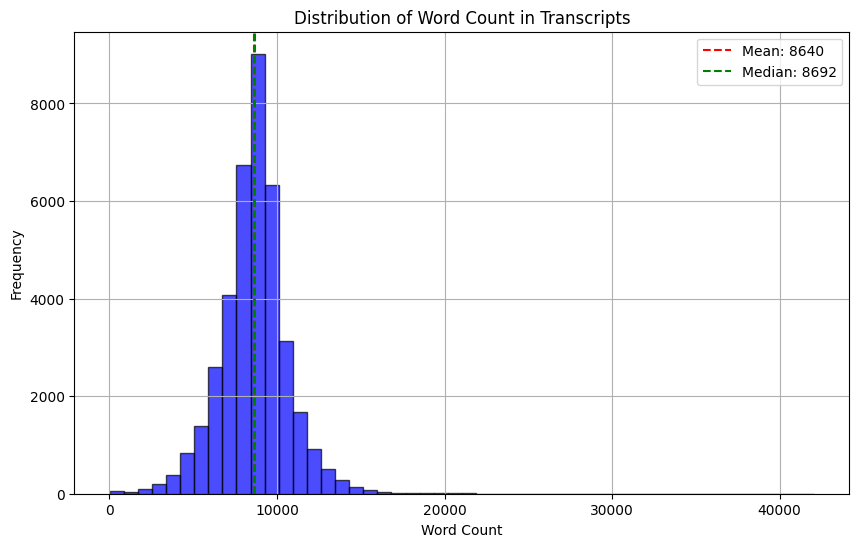

In [ ]:
df_count_word = pd.concat(list_df_count)

df_filtered = df_count_word[df_count_word['transcriptid'].isin(df_earnings_500_unique['transcriptid'])]

mean_count = df_filtered['count'].mean()
median_count = df_filtered['count'].median()

plt.figure(figsize=(10, 6))
plt.hist(df_filtered['count'], bins=50, color='blue', alpha=0.7, edgecolor='black')

plt.axvline(mean_count, color='red', linestyle='--', label=f'Mean: {mean_count:.0f}')
plt.axvline(median_count, color='green', linestyle='--', label=f'Median: {median_count:.0f}')

plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Count in Transcripts')
plt.legend()
plt.grid(True)

plt.show()

# FinGPT

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel


base_model = AutoModelForCausalLM.from_pretrained(
    'meta-llama/Llama-2-7b-chat-hf',
    trust_remote_code=True,
    device_map="auto",
    torch_dtype=torch.float16,   # optional if you have enough VRAM
)
tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-2-7b-chat-hf')

model = PeftModel.from_pretrained(base_model, 'FinGPT/fingpt-forecaster_dow30_llama2-7b_lora')
model = model.eval()

OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/meta-llama/Llama-2-7b-chat-hf.
401 Client Error. (Request ID: Root=1-67b9f299-4a4fae0c1582990d0afdfc17;02c6f9a8-b81d-4f3a-9805-74aa04b19add)

Cannot access gated repo for url https://huggingface.co/meta-llama/Llama-2-7b-chat-hf/resolve/main/config.json.
Access to model meta-llama/Llama-2-7b-chat-hf is restricted. You must have access to it and be authenticated to access it. Please log in.